<img src="../Images/DSC_Logo.png" style="width: 400px;">

# Plancton Assemblage

![core](../Images/core_foraminifera.png)

*Image modified from Northwestern University and T. Boeschen, GEOMAR*

This notebook analyzes a dataset detailing plankton assemblage changes over the past 24,000 years, correlating these shifts with climatic data. The dataset includes three CSV files: planktonic foraminifera time series, metadata, and climatic time series data. Principal Component Analysis (PCA) and Generalized Additive Models (GAM) are used to explore biodiversity trends and responses to climate change. 

**Original dataset and code:** Strack, T., Jonkers, L., Rillo, M. C., Baumann, K.-H., Hillebrand, H., & Kucera, M.: Harmonized data and R code for "Coherent response of zoo- and phytoplankton assemblages to global warming since the Last Glacial Maximum" [Data set]. Zenodo. doi:10.5281/zenodo.10803875,                    retrieved on August 12, 2024.

**Related publication:** Strack, T., Jonkers, L., C. Rillo, M., Baumann, K.-H., Hillebrand, H., and Kucera, M.: Coherent response of zoo‐ and phytoplankton assemblages to global warming since the Last Glacial Maximum, Global Ecol Biogeogr, 33, e13841, doi:10.1111/geb.13841,         2024.

Original data and code were modified for this notebook. The analyses presented here may not align with those published.

In [1]:
pip install statsmodels shapely geopandas cartopy scikit-learn seaborn

  Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
  Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached pyproj-3.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
Using cached Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl (24.1 MB)
Using cached pyproj-3.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)
Using cached pyshp-2.3.1-py2.py3-none-any.whl (46

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
pf_ts = pd.read_csv('../Datasets/planctonic_foraminifera/pf_data.csv') # planctonic foraminifera time series data
core_list = pd.read_csv('../Datasets/planctonic_foraminifera/core_list.csv') # planctonic foraminifera metadata
GMST = pd.read_csv('../Datasets/planctonic_foraminifera/GMST.csv') # climatic time series data

## 1. Prepare and Investigate Time Series and Locations

## 1.1 Time Series Structure

In [4]:
pf_ts.head(5)

,ID,Age_kaBP,Depth_m,Species,Rel_abundance
0,339-u1385_dinocyst,0.116505,0.02,Achomosphaera_spp,0.000000
1,339-u1385_dinocyst,0.757282,0.13,Achomosphaera_spp,0.002088
2,339-u1385_dinocyst,1.456311,0.25,Achomosphaera_spp,0.019068
3,339-u1385_dinocyst,1.864078,0.32,Achomosphaera_spp,0.004695
4,339-u1385_dinocyst,2.097087,0.36,Achomosphaera_spp,0.004264


There are multiple species per ID and time variables (age that relates to depth):

In [5]:
pf_ts.sample(5)

,ID,Age_kaBP,Depth_m,Species,Rel_abundance
60824,md99-2284_planktonic foraminifera,9.403308,1.165,Globoconella_inflata,0.016227
80187,162-980_planktonic foraminifera,1.386400,0.420,Globorotaloides_hexagonus,0.000000
15954,339-u1385_dinocyst,9.436893,1.620,Spiniferites_bentorii,0.000000
98948,m35003-4_planktonic foraminifera,22.716000,3.650,Tenuitella_iota,0.000000
98941,m35003-4_planktonic foraminifera,20.159091,3.300,Tenuitella_iota,0.000000


List of unique IDs that represent the individual samples:

In [6]:
ID_list = pf_ts['ID'].unique()
print(ID_list)

['339-u1385_dinocyst' 'geob5546-2_dinocyst' 'kzai-01_dinocyst'
 'md95-2002_dinocyst' 'md99-2285_dinocyst' 'md99-2339_dinocyst'
 '162-980_coccolithophore' '162-984c_coccolithophore'
 'geob11035-1_coccolithophore' 'geob3104-1_coccolithophore'
 'geob5546-2_coccolithophore' 'm35003-4_coccolithophore'
 '108-658c_planktonic foraminifera' '161-977a_planktonic foraminifera'
 '162-980_planktonic foraminifera' 'ch69-k09_planktonic foraminifera'
 'gik15612-2_planktonic foraminifera' 'gik17730-4_planktonic foraminifera'
 'm35003-4_planktonic foraminifera' 'md95-2040_planktonic foraminifera'
 'md95-2041_planktonic foraminifera' 'md95-2042_planktonic foraminifera'
 'md95-2043_planktonic foraminifera' 'md99-2284_planktonic foraminifera'
 'md99-2285_planktonic foraminifera' 'md99-2339_planktonic foraminifera'
 'rc24-16_planktonic foraminifera' 'su90-i03_planktonic foraminifera'
 'su92-03_planktonic foraminifera' 'v22-222_planktonic foraminifera'
 'v25-59_planktonic foraminifera' 'v25-75_planktonic for

## 1.2 Create wide-format datasets for each ID and store them in a dictionary

In wide format, each species (defined by the 'Species' column) becomes a separate column, allowing for quick and direct access to individual species' abundance data. This makes it easier to perform calculations, comparisons, and visualizations on specific variables without needing to filter or reshape the dataset continuously.

In [7]:
pf_ts_wide = {}

for i in pf_ts['ID'].unique():
    wide_i = pf_ts[pf_ts['ID'] == i].pivot_table(
        index=['Depth_m', 'Age_kaBP'], 
        columns='Species', 
        values='Rel_abundance', 
        fill_value=0
    )
    pf_ts_wide[i] = wide_i

In [8]:
ID = '339-u1385_dinocyst'
pf_ts_wide[ID].head(5)

,Species,Achomosphaera_spp,Ataxiodinium_choanum,Bitectatodinium_spongium,Bitectatodinium_tepikiense,Brigantedinium_spp,Dalella_chathamensis,Echinidinium_aculeatum,Echinidinium_delicatum,Echinidinium_granulatum,Echinidinium_karaense,...,Spiniferites_mirabilis,Spiniferites_ramosus,Spiniferites_spp,Tectatodinium_pellitum,Trinovantedinium_applanatum,Trinovantedinium_variable,Tuberculodinium_vancampoae,Votadinium_calvum,Votadinium_spinosum,Xandarodinium_xanthum
Depth_m,Age_kaBP,,,,,,,,,,,,,,,,,,,,,
0.02,0.116505,0.000000,0.0,0.0,0.001037,0.036307,0.0,0.000000,0.007261,0.0,0.0,...,0.026971,0.132780,0.0,0.0,0.009336,0.0,0.0,0.0,0.001037,0.0
0.13,0.757282,0.002088,0.0,0.0,0.000000,0.144050,0.0,0.000000,0.014614,0.0,0.0,...,0.016701,0.110647,0.0,0.0,0.012526,0.0,0.0,0.0,0.000000,0.0
0.25,1.456311,0.019068,0.0,0.0,0.000000,0.093220,0.0,0.000000,0.025424,0.0,0.0,...,0.014831,0.146186,0.0,0.0,0.016949,0.0,0.0,0.0,0.008475,0.0
0.32,1.864078,0.004695,0.0,0.0,0.000000,0.124413,0.0,0.011737,0.007042,0.0,0.0,...,0.016432,0.105634,0.0,0.0,0.002347,0.0,0.0,0.0,0.002347,0.0
0.36,2.097087,0.004264,0.0,0.0,0.000000,0.134328,0.0,0.000000,0.036247,0.0,0.0,...,0.017058,0.104478,0.0,0.0,0.023454,0.0,0.0,0.0,0.008529,0.0


## 1.3 Check Rel_abundance column for an example ID and time

Select example ID and time via depth:

In [9]:
ID = '339-u1385_dinocyst'
depth = 0.02

Check in the original (long format) data:

In [10]:
long_sum = pf_ts[(pf_ts['ID'] == ID) & (pf_ts['Depth_m'] == depth)]['Rel_abundance'].sum() 
print(f"Long format sum: {long_sum * 100:.2f}%")

Long format sum: 100.00%


Check in the transformed (wide format) data:

In [11]:
wide_sum = pf_ts_wide[ID].loc[depth].sum().sum() 
print(f"Wide format sum: {wide_sum * 100:.2f}%")

Wide format sum: 100.00%


## 1.4 Plot locations on map from metadata

Load additional packages for plotting:

In [12]:
from shapely.geometry import Point
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Create a dictionary for colors:

In [13]:
foraminifera_colors = {
    'planktonic foraminifera': '#9D9E9E',
    'coccolithophore': '#36648B',
    'dinocyst': '#CD950C'
}

Create a geodataframe from the dataframe:

In [14]:
geometry = [Point(xy) for xy in zip(core_list['lon'], core_list['lat'])]
gdf = gpd.GeoDataFrame(core_list, geometry=geometry)

Plot:

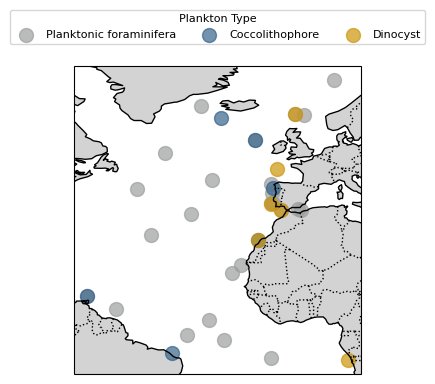

In [15]:
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.LAND, edgecolor='black', color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='white')  # Set ocean color to white
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

for plankton_type, color in foraminifera_colors.items():
    subset = gdf[gdf['Plankton'] == plankton_type]
    subset.plot(ax=ax, marker='o', color=color, markersize=100, alpha=0.7, transform=ccrs.PlateCarree(), label=plankton_type.capitalize())

ax.legend(title='Plankton Type', loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize=8, title_fontsize=8)

plt.show()

## **Exercise 1: Dimensionality Reduction in Time Series**

The study utilized PCA to streamline species assemblage data at each site, emphasizing key temporal changes. By extracting the first principal component (PC1), the analysis captured the majority of variance, enabling an understanding of site-specific shifts in species composition over time.

## 2. Principal Component Analysis (PCA)

**Exercise:** Import functions for conducting PCA analysis with the standardized dataset from the `sklearn` library.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Workflow for a single ID:

**Exercise:** Get a list of all unique sample IDs in the original time series *pf_ts* and select a single ID, which you define as a new variable named *ID*.

In [17]:
unique_ids = pf_ts['ID'].unique()
print(unique_ids)
ID = '339-u1385_dinocyst'

['339-u1385_dinocyst' 'geob5546-2_dinocyst' 'kzai-01_dinocyst'
 'md95-2002_dinocyst' 'md99-2285_dinocyst' 'md99-2339_dinocyst'
 '162-980_coccolithophore' '162-984c_coccolithophore'
 'geob11035-1_coccolithophore' 'geob3104-1_coccolithophore'
 'geob5546-2_coccolithophore' 'm35003-4_coccolithophore'
 '108-658c_planktonic foraminifera' '161-977a_planktonic foraminifera'
 '162-980_planktonic foraminifera' 'ch69-k09_planktonic foraminifera'
 'gik15612-2_planktonic foraminifera' 'gik17730-4_planktonic foraminifera'
 'm35003-4_planktonic foraminifera' 'md95-2040_planktonic foraminifera'
 'md95-2041_planktonic foraminifera' 'md95-2042_planktonic foraminifera'
 'md95-2043_planktonic foraminifera' 'md99-2284_planktonic foraminifera'
 'md99-2285_planktonic foraminifera' 'md99-2339_planktonic foraminifera'
 'rc24-16_planktonic foraminifera' 'su90-i03_planktonic foraminifera'
 'su92-03_planktonic foraminifera' 'v22-222_planktonic foraminifera'
 'v25-59_planktonic foraminifera' 'v25-75_planktonic for

We retrieve the wide-format DataFrame for the given ID from the *pf_ts_wide* dictionary and name it *pf_ts_wide_i*.

In [18]:
pf_ts_wide_i = pf_ts_wide.get(ID)
pf_ts_wide_i.head()

,Species,Achomosphaera_spp,Ataxiodinium_choanum,Bitectatodinium_spongium,Bitectatodinium_tepikiense,Brigantedinium_spp,Dalella_chathamensis,Echinidinium_aculeatum,Echinidinium_delicatum,Echinidinium_granulatum,Echinidinium_karaense,...,Spiniferites_mirabilis,Spiniferites_ramosus,Spiniferites_spp,Tectatodinium_pellitum,Trinovantedinium_applanatum,Trinovantedinium_variable,Tuberculodinium_vancampoae,Votadinium_calvum,Votadinium_spinosum,Xandarodinium_xanthum
Depth_m,Age_kaBP,,,,,,,,,,,,,,,,,,,,,
0.02,0.116505,0.000000,0.0,0.0,0.001037,0.036307,0.0,0.000000,0.007261,0.0,0.0,...,0.026971,0.132780,0.0,0.0,0.009336,0.0,0.0,0.0,0.001037,0.0
0.13,0.757282,0.002088,0.0,0.0,0.000000,0.144050,0.0,0.000000,0.014614,0.0,0.0,...,0.016701,0.110647,0.0,0.0,0.012526,0.0,0.0,0.0,0.000000,0.0
0.25,1.456311,0.019068,0.0,0.0,0.000000,0.093220,0.0,0.000000,0.025424,0.0,0.0,...,0.014831,0.146186,0.0,0.0,0.016949,0.0,0.0,0.0,0.008475,0.0
0.32,1.864078,0.004695,0.0,0.0,0.000000,0.124413,0.0,0.011737,0.007042,0.0,0.0,...,0.016432,0.105634,0.0,0.0,0.002347,0.0,0.0,0.0,0.002347,0.0
0.36,2.097087,0.004264,0.0,0.0,0.000000,0.134328,0.0,0.000000,0.036247,0.0,0.0,...,0.017058,0.104478,0.0,0.0,0.023454,0.0,0.0,0.0,0.008529,0.0


**Exercise:** Standardize the data before applying PCA. Name the standardized data *pf_ts_wide_i_scaled*:

In [19]:
scaler = StandardScaler()
pf_ts_wide_i_scaled = scaler.fit_transform(pf_ts_wide_i)

**Exercise:** Apply the PCA to find five Principal Components (PCs). Save the resulting PC values as *pca_scores* and print it:

In [20]:
pca = PCA(n_components=5)
pca_scores = pca.fit_transform(pf_ts_wide_i_scaled)
print(pca_scores)

[[-2.24412124e+00 -1.55478807e+00 -1.99364721e+00  3.87343796e-01
  -9.40369997e-01]
 [-2.09153583e+00 -2.22713987e+00 -5.25594181e-01  6.10274511e-01
   1.43552819e-01]
 [-3.50334689e+00 -3.60011141e+00 -2.94731776e+00  3.11086669e+00
  -1.88084086e+00]
 [-1.22164220e+00 -1.90593808e+00 -1.22517070e+00  1.57184897e+00
   1.98905642e+00]
 [-2.90242349e+00 -1.32653336e+00 -2.98284905e+00  3.10656291e-01
  -6.89646254e-01]
 [-1.95960417e+00 -1.62710646e+00 -2.49502875e-01 -5.37650248e-01
  -4.40267849e-01]
 [-1.51496689e+00 -2.39283039e+00 -2.37631205e+00  1.12465605e+00
   1.01051970e+00]
 [-1.63256780e+00 -1.95801452e+00 -1.80408761e+00  7.04845290e-01
   2.07234581e-01]
 [-2.68808463e+00  2.43401733e-01 -7.55243245e-01 -2.36359368e-01
  -1.44957809e-01]
 [-3.75468837e+00 -1.21803111e-01 -1.30125554e+00 -1.79296896e+00
  -1.15598615e+00]
 [-3.52858786e+00 -4.95529476e-01 -1.72476204e-01  2.57845511e-01
   1.19953861e-01]
 [-5.76725730e+00 -6.11313318e-01  4.59614295e-01  1.80808356e-01

**Exercise:** Extract the explained variance ratio from the PCA, save it as *evr* and print it. In addition, plot the explained variance ratio. How much variance is explained by the first PC alone?

In [21]:
evr = pca.explained_variance_ratio_
print(evr)

[0.23058439 0.07481367 0.07293607 0.06247    0.05440505]


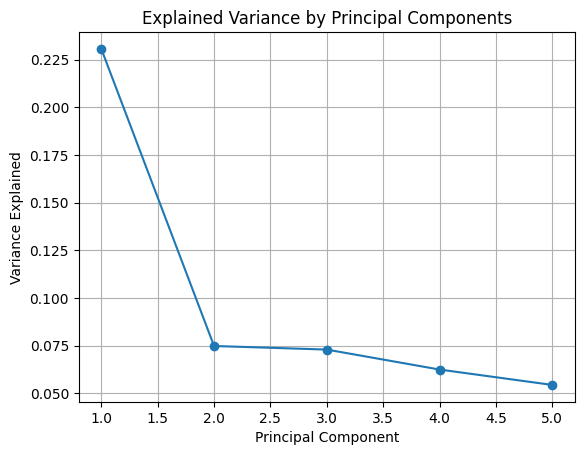

In [22]:
plt.figure()
plt.plot(range(1, 6), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid()
plt.show()

We create a DataFrame out of the *pca_scores* and the *evr* values that aligns with the time index of *pf_ts_wide_i* for analyzing how the PCs relate to time and time-dependend conditions.

In [23]:
pca_scores = pd.DataFrame(pca_scores, index=pf_ts_wide_i.index, columns=['PC1','PC2','PC3','PC4','PC5'])
pca_scores['PC1_Var'] = evr[0]
pca_scores['PC2_Var'] = evr[1]
pca_scores['PC3_Var'] = evr[2]
pca_scores['PC4_Var'] = evr[3]
pca_scores['PC5_Var'] = evr[4]
pca_scores.head(5)

,,PC1,PC2,PC3,PC4,PC5,PC1_Var,PC2_Var,PC3_Var,PC4_Var,PC5_Var
Depth_m,Age_kaBP,,,,,,,,,,
0.02,0.116505,-2.244121,-1.554788,-1.993647,0.387344,-0.940370,0.230584,0.074814,0.072936,0.06247,0.054405
0.13,0.757282,-2.091536,-2.227140,-0.525594,0.610275,0.143553,0.230584,0.074814,0.072936,0.06247,0.054405
0.25,1.456311,-3.503347,-3.600111,-2.947318,3.110867,-1.880841,0.230584,0.074814,0.072936,0.06247,0.054405
0.32,1.864078,-1.221642,-1.905938,-1.225171,1.571849,1.989056,0.230584,0.074814,0.072936,0.06247,0.054405
0.36,2.097087,-2.902423,-1.326533,-2.982849,0.310656,-0.689646,0.230584,0.074814,0.072936,0.06247,0.054405


We run the workflow in a function for every ID using only the first PC as in the orinal study:

In [24]:
def pca_analysis(df):

    # Standardize the data before applying PCA
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Apply PCA analysis
    pca = PCA(n_components=1) # 3
    pca_scores = pca.fit_transform(df_scaled)
    eig_val = pca.explained_variance_ratio_ * 100
    
    # Prepare PCA result DataFrame, align with index
    pca_scores = pd.DataFrame(pca_scores, index=df.index, columns=['PC1']) # , 'PC2', 'PC3'
    pca_scores['PC1_Var'] = eig_val[0]
    #pca_scores['PC2_Var'] = eig_val[1]
    #pca_scores['PC3_Var'] = eig_val[2]

    # Reset index to get back time information as column
    pca_scores.reset_index(inplace=True)
    
    return pca_scores 

pca_results = {i: pca_analysis(pf_ts_wide[i]) for i in ID_list}

We create a DataFrame consisting of the sample ID and the explained variance ratio of PC1:

In [25]:
rows = []
for site_id, df in pca_results.items():
    var_value = df['PC1_Var'].iloc[0]  # 'PC1_Var' is the same for all rows within the DataFrame
    rows.append({'ID': site_id, 'Dim.1_Var': var_value})

# Convert the list of rows into a DataFrame
pca_var_df = pd.DataFrame(rows)

We can well investigate the explained variance per plankton group using boxplots:

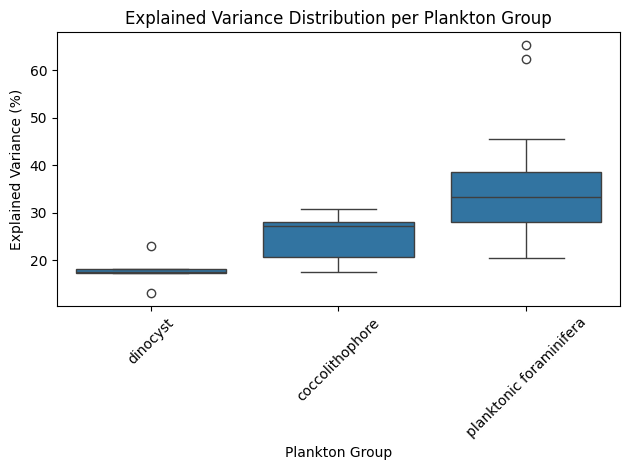

                     Group       mean        min        max
0          coccolithophore  24.916849  17.453223  30.701590
1                 dinocyst  17.776913  13.039837  23.058439
2  planktonic foraminifera  35.137092  20.413463  65.320188


In [26]:
# Group the explained variance by plankton group
# Example IDs could be structured like 'ID_planktonic foraminifera', so split based on expected patterns
pca_var_df['Group'] = pca_var_df['ID'].apply(lambda x: x.split('_')[1] if '_' in x else x)

# Calculate the explained variance ranges for each plankton group
explained_variance_grouped = pca_var_df.groupby('Group')['Dim.1_Var'].agg(['mean', 'min', 'max']).reset_index()

# Boxplot of the explained variance per group
import seaborn as sns
plt.figure()
sns.boxplot(x='Group', y='Dim.1_Var', data=pca_var_df)
plt.title('Explained Variance Distribution per Plankton Group')
plt.xlabel('Plankton Group')
plt.ylabel('Explained Variance (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

explained_variance_grouped = pca_var_df.groupby('Group')['Dim.1_Var'].agg(['mean', 'min', 'max']).reset_index()
print(explained_variance_grouped)

The first principal component (PC1) of each group explains a varying proportion of the variance, with planktonic foraminifera showing the highest (20%–65%) and coccolithophores showing the lowest (17%–31%).

In addition, we aim to plot the explained variance on the map using the sample locations that are available in the dataset *core_list*. For that we first need to `merge` the two DataFrames *core_list* and *pca_var_df*:

In [27]:
core_list_var = core_list.merge(pca_var_df, on='ID', how='left')

Then we can turn the DataFrame into a geodataframe (check out the library `geopandas`) which we then plot:

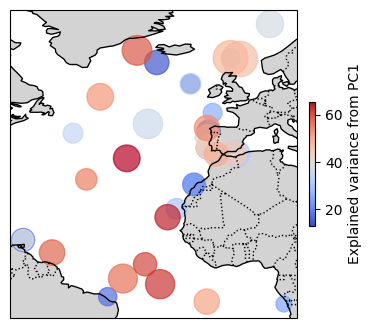

In [28]:
# Create geometry for GeoDataFrame using longitude and latitude
geometry = [Point(xy) for xy in zip(core_list_var['lon'], core_list_var['lat'])]
gdf = gpd.GeoDataFrame(core_list_var, geometry=geometry)

# Plot with Cartopy
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.LAND, edgecolor='black', color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='white')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Plot all data points on the map
# Use Dim.1_Var to determine the size of the markers
gdf.plot(ax=ax, marker='o', c=core_list_var['Dim.1_Var'], cmap='coolwarm', markersize=core_list_var['Dim.1_Var'] * 10,
         alpha=0.7, transform=ccrs.PlateCarree(), legend=True)

# Add a colorbar
colorbar = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=core_list_var['Dim.1_Var'].min(), vmax=core_list_var['Dim.1_Var'].max()))
colorbar._A = []  # Dummy array for the colorbar
cbar = fig.colorbar(colorbar, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Explained variance from PC1')

# Show the plot
plt.show()

## **Exercise 2: Time Series Pre-processing**

The study examined how species groups evolve over time using PCA. PCA can sometimes reverse the direction of its components while preserving the underlying data patterns. To ensure all samples exhibit the same trend direction, a specific function is applied. This guarantees that trends — whether increasing or decreasing over time — remain consistent and are easier to compare across different samples. 

In [29]:
def adjust_pc1_trend(df, site_id):

    df = df.copy()
    
    if len(df['Age_kaBP'].unique()) > 1:
        
        # Prepare the independent and dependent variables
        X = df['Age_kaBP']
        y = df['PC1']
        
        # Add a constant to the independent variable
        X_const = sm.add_constant(X)  # This adds an intercept term
        
        # Fit the model
        model = sm.OLS(y, X_const).fit()
        
        # Extract the slope
        slope = model.params[1]  # params[1] gives the slope, params[0] gives the intercept
    else:
        slope = 0

    # Set PC1_slope and adjust PC1 if necessary
    df['PC1_slope'] = slope
    if slope > 0:
        print(f"Adjusting slope for {site_id}: {slope}")
        df['PC1'] *= -1

    return df

In [30]:
adjusted_pca_results = {site_id: adjust_pc1_trend(pca_results[site_id], site_id) for site_id in ID_list}

Adjusting slope for 339-u1385_dinocyst: 0.3562689240721079
Adjusting slope for kzai-01_dinocyst: 0.10808109408755416
Adjusting slope for md99-2285_dinocyst: 0.2196088797500896
Adjusting slope for 162-984c_coccolithophore: 0.1592880273164356
Adjusting slope for geob3104-1_coccolithophore: 0.23124236341241106
Adjusting slope for m35003-4_coccolithophore: 0.3546197598296837
Adjusting slope for 108-658c_planktonic foraminifera: 0.24162249459558416
Adjusting slope for gik17730-4_planktonic foraminifera: 0.14636405537331665
Adjusting slope for m35003-4_planktonic foraminifera: 0.3361042510575503
Adjusting slope for md95-2042_planktonic foraminifera: 0.23434435610149856
Adjusting slope for md95-2043_planktonic foraminifera: 0.39454208255303447
Adjusting slope for md99-2284_planktonic foraminifera: 0.239364176981204
Adjusting slope for md99-2285_planktonic foraminifera: 0.2426037899140523
Adjusting slope for rc24-16_planktonic foraminifera: 0.3428202689136533
Adjusting slope for su90-i03_plank

/tmp/ipykernel_792/1216522561.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]  # params[1] gives the slope, params[0] gives the intercept
/tmp/ipykernel_792/1216522561.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]  # params[1] gives the slope, params[0] gives the intercept
/tmp/ipykernel_792/1216522561.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.param

In the output of the previous code block we find the samples for which PC1 scores were adjusted to slope. We now want to verify the adjustment in the 'adjusted_pca_results' dictionary compared to the 'pca_results' dictionary. For this, we first select one sample printed in the output and extract it's values from the dictionaries:

In [31]:
# Choose ID
ID = '339-u1385_dinocyst'

# Extract the dataframe for the specified site ID
df = pca_results[ID]
df2 = adjusted_pca_results[ID]

# Extract PC1 scores and Age_kaBP values
y = df['PC1'].values
y2 = df2['PC1'].values
X = df['Age_kaBP'].values

**Exercise:** Plot the PC1 scores together with the linear regression line for the PC1 values of the sample together with the PC1 scores after the adjustment. 

## 3. Data Availability and Interpolation

The study used interpolation to create a consistent comparison of the first PC scores for planktonic foraminifera even though the individual time series have different time resolutions. They interpolated the first PC scores in 0.5 thousand-year (kyr) bins to better align the data for easier comparison of different samples. 

In [32]:
# Combine all interpolated PC1 scores into a long format DataFrame
adjusted_pca_results_long = pd.concat([df.assign(ID=id) for id, df in adjusted_pca_results.items()], ignore_index=True)

# Create a binary availability indicator
adjusted_pca_results_long['Availability'] = adjusted_pca_results_long['PC1'].notnull().astype(int) # Mark as 1 where PC1 data is available, else 0

# Pivot the DataFrame
heatmap_data = adjusted_pca_results_long.pivot_table(index='ID', columns='Age_kaBP', values='Availability', aggfunc='max')

In [33]:
heatmap_data

Age_kaBP,0.000000,0.116505,0.118579,0.138000,0.158625,0.168263,0.187583,0.204517,0.359333,0.384256,...,23.927111,23.942293,23.942935,23.949822,23.958644,23.964851,23.973421,23.991760,23.991795,24.000000
ID,,,,,,,,,,,,,,,,,,,,,
108-658c_planktonic foraminifera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161-977a_planktonic foraminifera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162-980_coccolithophore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162-980_planktonic foraminifera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162-984c_coccolithophore,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339-u1385_dinocyst,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
ch69-k09_planktonic foraminifera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geob11035-1_coccolithophore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geob3104-1_coccolithophore,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Exercise:** Let's investigate the data availability for the different samples using a heatmap plot (`seaborn` library). We created a long format DataFrame out of the dictionary for this task and named it 'adjusted_pca_results_long' and pivoted the data afterwards. Investigate 'heatmap_data' and plot the heatmap.

Age_kaBP                          0.000000   0.116505   0.118579   0.138000   \
ID                                                                             
108-658c_planktonic foraminifera        NaN        NaN        NaN        NaN   
161-977a_planktonic foraminifera        NaN        NaN        NaN        NaN   
162-980_coccolithophore                 NaN        NaN        NaN        NaN   
162-980_planktonic foraminifera         NaN        NaN        NaN        NaN   
162-984c_coccolithophore                NaN        NaN        NaN        1.0   

Age_kaBP                          0.158625   0.168263   0.187583   0.204517   \
ID                                                                             
108-658c_planktonic foraminifera        NaN        NaN        NaN        NaN   
161-977a_planktonic foraminifera        NaN        NaN        NaN        NaN   
162-980_coccolithophore                 NaN        NaN        NaN        NaN   
162-980_planktonic foraminifera        

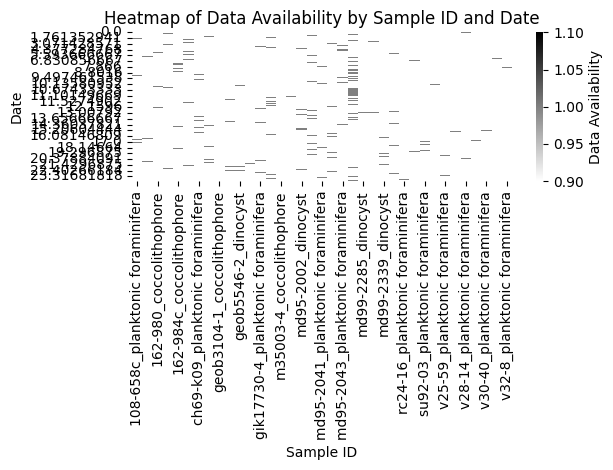

In [34]:
# prepare data for heatmap
#heatmap_data = data_exp.notna().astype(int)  # Convert to binary (1 for available, 0 for NaN)
#heatmap_data = heatmap_data.T
print(heatmap_data.head())

# plot heatmap
import seaborn as sns
plt.figure()  
sns.heatmap(heatmap_data.T, cmap='binary', cbar_kws={'label': 'Data Availability'}, annot=False)
plt.title("Heatmap of Data Availability by Sample ID and Date")
plt.xlabel("Sample ID")
plt.ylabel("Date")
plt.tight_layout()
plt.show()

**Exercise:** Standardize age data across different samples by interpolating values to a common set of dates. First define a sequence of 0.5 thousand-year (kyr) bins from 0 to 24.5 kaBP using the `np.arange` function. Name it 'seq_interpol'.

In [35]:
seq_interpol = np.arange(0, 24.5, 0.5)

In [36]:
X

array([ 0.11650485,  0.75728155,  1.45631068,  1.86407767,  2.09708738,
        2.50485437,  2.79611651,  3.08737864,  3.4368932 ,  3.84466019,
        4.0776699 ,  4.48543689,  4.77669903,  5.12621359,  5.41747573,
        5.70873786,  6.05825243,  6.46601942,  6.75728155,  7.16504854,
        7.39805825,  7.74757282,  8.03883495,  8.27184466,  8.5631068 ,
        8.85436893,  9.4368932 ,  9.96116505, 10.54368932, 11.12621359,
       11.65048544, 12.186     , 12.806     , 13.364     , 13.984     ,
       14.542     , 15.162     , 15.72      , 16.278     , 16.898     ,
       17.58      , 18.138     , 18.758     , 19.378     , 19.91187091,
       20.31654818, 20.72122544, 21.12590271, 21.53057998, 21.93525725,
       22.33993452, 22.74461179, 23.14928906, 23.55396632, 23.95864359])

In [37]:
values = X.reshape((len(X), 1))
values

array([[ 0.11650485],
       [ 0.75728155],
       [ 1.45631068],
       [ 1.86407767],
       [ 2.09708738],
       [ 2.50485437],
       [ 2.79611651],
       [ 3.08737864],
       [ 3.4368932 ],
       [ 3.84466019],
       [ 4.0776699 ],
       [ 4.48543689],
       [ 4.77669903],
       [ 5.12621359],
       [ 5.41747573],
       [ 5.70873786],
       [ 6.05825243],
       [ 6.46601942],
       [ 6.75728155],
       [ 7.16504854],
       [ 7.39805825],
       [ 7.74757282],
       [ 8.03883495],
       [ 8.27184466],
       [ 8.5631068 ],
       [ 8.85436893],
       [ 9.4368932 ],
       [ 9.96116505],
       [10.54368932],
       [11.12621359],
       [11.65048544],
       [12.186     ],
       [12.806     ],
       [13.364     ],
       [13.984     ],
       [14.542     ],
       [15.162     ],
       [15.72      ],
       [16.278     ],
       [16.898     ],
       [17.58      ],
       [18.138     ],
       [18.758     ],
       [19.378     ],
       [19.91187091],
       [20

In [38]:
from sklearn.preprocessing import StandardScaler
from math import sqrt

# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)

# standardization the dataset and print the first 5 rows
normalized = scaler.transform(values)
print(normalized[:5])
    
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
print(inversed[:5])

[[-1.57054894]
 [-1.48116831]
 [-1.38366216]
 [-1.32678358]
 [-1.29428153]]
[[0.11650485]
 [0.75728155]
 [1.45631068]
 [1.86407767]
 [2.09708738]]


In [39]:
print("Min value normalized:", min(normalized))
print("Max value normalized:", max(normalized))

Min value normalized: [-1.57054894]
Max value normalized: [1.75514234]


In [40]:
# Dictionary to store interpolated results by ID
pca_time_series = {}

**Exercise:** Then 1) drop NaN values for the interpolation, 2) interpolate values using the `interp1d` function and 3) extract the dates from the sequence from the interpolated data. Apply these steps for each time series individually using a `for` loop. Because the time series/ DataFrames are stored in the dictionary, we need to call each time series as follows in the loop: `for site_id, df in adjusted_pca_results.items():` At the end of the loop, store the results (name: 'interpolated_values') to the 'pca_time_series' dictionary using `pca_time_series[site_id] = pd.DataFrame({'Age_kaBP': seq_interpol, 'PC1_score': interpolated_values})`.

In [43]:
from scipy.interpolate import interp1d

# Create a new DataFrame for storing interpolated results
results = pd.DataFrame(index=seq_interpol)

# Interpolation for each column in the data DataFrame
for site_id, df in adjusted_pca_results.items():

    # 1. Drop NaN values for interpolation
    df = df.dropna(subset=['Values'])
    
    # 2. Interpolate using linear interpolation
    # Ensure to use the 'Year' for interpolation
    f = interp1d(df['Age_kaBP'], df['PC1'], 
                 kind='linear', bounds_error=False, fill_value=np.nan)
    
    # 3. Get interpolated values for the predefined sequence
    interpolated_values = f(seq_interpol)

    # Store interpolated values in the yearly results DataFrame
    results[column] = interpolated_values

# Example of accessing the interpolated data
print(results)

KeyError: ['Values']

In [ ]:
# Plotting the original data and the filled data
plt.figure()
plt.plot(yearly_results, label='Original Data', color='b')
plt.title('Yearly aggregated data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid()
plt.tight_layout()
plt.show()

**Exercise:** Print the new PC1 scores for a sample of your choice using `pca_time_series[i]`.

**Exercise:** Repeat plotting the heatmap of data availability with the new dataset. First create pivoted data as before. Then plot the heatmap.

## **Exercise 3: Time Series Prediction**

## 4. Generalized Additive Model (GAM)

Generalized Additive Models (GAMs) were used in the study to analyze the complex relationships between environmental factors (like temperature) and the response of planktonic foraminifera assemblages over time.

## 4.1 Select Data for Modeling

To avoid edge effects, the study focused on time periods that all the samples covered. This approach helped ensure that the comparisons of biodiversity changes over time are not influenced by differences in data collection. Subsets were created for planktonic foraminifera, dinocysts, and coccolithophores based on their IDs, facilitating focused analyses on each group's responses to climate change. In the end, the following codeblock provides 1. variables for fitting the GAM models and 2. Sets of ages over which we will predict trends in the planktonic community data using the fitted GAMs. 

In [ ]:
# Combine all interpolated PC1 scores into a long format DataFrame
interpolation_long = pd.concat([df.assign(ID=id) for id, df in pca_time_series.items()], ignore_index=True)

# Create subsets for each plankton group based on the ID column
interpolation_long_PF = interpolation_long[interpolation_long['ID'].str.contains('_planktonic foraminifera')]
interpolation_long_dino = interpolation_long[interpolation_long['ID'].str.contains('_dinocyst')]
interpolation_long_cocco = interpolation_long[interpolation_long['ID'].str.contains('_coccolithophore')]

# Adjust the data to set Age_kaBP to NaN where PC1_score is NaN
def adjust_for_nan(df):
    df.loc[df['PC1_score'].isna(), 'Age_kaBP'] = np.nan
    return df

# Group DataFrames
interpolation_long_PF = adjust_for_nan(interpolation_long_PF)
interpolation_long_dino = adjust_for_nan(interpolation_long_dino)
interpolation_long_cocco = adjust_for_nan(interpolation_long_cocco)

# Determine the Common Age Range
def get_common_age_range(interpolation_long_group):
    # Extract the minimum and maximum ages across all time series
    min_age = interpolation_long_group.groupby('ID')['Age_kaBP'].min().max()
    max_age = interpolation_long_group.groupby('ID')['Age_kaBP'].max().min()
    return min_age, max_age

# Group Common Age Range 
pf_min_age, pf_max_age = get_common_age_range(interpolation_long_PF)
cocco_min_age, cocco_max_age = get_common_age_range(interpolation_long_cocco)
dino_min_age, dino_max_age = get_common_age_range(interpolation_long_dino) 

# Data used for fitting GAM and model predictions:

# 1. Independent variable (predictor) and dependent variable (target) without any NaN values
# (e.g. age_kabp_valid_PF is the valid predictor and pc1_score_valid_PF is the valid target for planktonic foraminifera)
age_kabp_PF = interpolation_long_PF['Age_kaBP']
pc1_score_PF = interpolation_long_PF['PC1_score']
valid_indices_PF = ~np.isnan(age_kabp_PF) & ~np.isnan(pc1_score_PF)
age_kabp_valid_PF = age_kabp_PF[valid_indices_PF]
pc1_score_valid_PF = pc1_score_PF[valid_indices_PF]
age_kabp_dino = interpolation_long_dino['Age_kaBP']
pc1_score_dino = interpolation_long_dino['PC1_score']
valid_indices_dino = ~np.isnan(age_kabp_dino) & ~np.isnan(pc1_score_dino)
age_kabp_valid_dino = age_kabp_dino[valid_indices_dino]
pc1_score_valid_dino = pc1_score_dino[valid_indices_dino]
age_kabp_cocco = interpolation_long_cocco['Age_kaBP']
pc1_score_cocco = interpolation_long_cocco['PC1_score']
valid_indices_cocco = ~np.isnan(age_kabp_cocco) & ~np.isnan(pc1_score_cocco)
age_kabp_valid_cocco = age_kabp_cocco[valid_indices_cocco]
pc1_score_valid_cocco = pc1_score_cocco[valid_indices_cocco]

# 2. Sets of ages (predictor) over which we will predict trends in the planktonic community data using the fitted GAMs
N = 2000 # Number of points to evaluate the smooth
Age_range_PF = np.linspace(pf_min_age, pf_max_age, N)
Age_range_cocco = np.linspace(cocco_min_age, cocco_max_age, N)
Age_range_dino = np.linspace(dino_min_age, dino_max_age, N)


## 4.2 Fit GAM

**Exercise:** Fit a Generalized Additive Model (GAM) for each plankton group by creating 15 basis splines from their respective valid age ranges.

## 4.3 Predict

**Exercise:** Now create spline basis functions from predefined age ranges for the prediction task.

The fitted GAMs can now be used to generate predictions for the defined age ranges based on the newly defined spline basis functions. This step quantifies the expected responses over the defined age ranges, providing insights into the relationships between age and PC1 scores for each group. We account for uncertainty by calculating the confidence intervals alongside the predicted values. We store the results in DataFrames that include the fitted values and their corresponding lower and upper confidence bounds for further analysis in plots.

In [ ]:
# Generate predictions and confidence intervals for planktonic foraminifera
preds_PF = mod_PF.get_prediction(bsplines_PF).summary_frame(alpha=0.05)

# Generate predictions and confidence intervals for coccolithophores
preds_cocco = mod_cocco.get_prediction(bsplines_cocco).summary_frame(alpha=0.05)

# Generate predictions and confidence intervals for dinocysts
preds_dino = mod_dino.get_prediction(bsplines_dino).summary_frame(alpha=0.05)

GAM_PF = pd.DataFrame({
   "Age_kaBP": Age_range_PF,  # Match the length of predictions
   "fit": preds_PF["mean"],
   "lower": preds_PF["mean_ci_lower"],
   "upper": preds_PF["mean_ci_upper"]
})

# Create a DataFrame with the predictions and confidence intervals
GAM_cocco = pd.DataFrame({
    "Age_kaBP": Age_range_cocco,  # Use Age_range_cocco directly
    "fit": preds_cocco["mean"],
    "lower": preds_cocco["mean_ci_lower"],
    "upper": preds_cocco["mean_ci_upper"]
})

# Create a DataFrame with the predictions and confidence intervals
GAM_dino = pd.DataFrame({
    "Age_kaBP": Age_range_dino,  # Use Age_range_dino directly
    "fit": preds_dino["mean"],
    "lower": preds_dino["mean_ci_lower"],
    "upper": preds_dino["mean_ci_upper"]
})

results = {
    'dinocyst': {'data': interpolation_long_dino, 'gam': GAM_dino, 'color': '#CD950C', 'label': 'Dinocysts', 'min_age': dino_min_age, 'max_age': dino_max_age},
    'coccolithophore': {'data': interpolation_long_cocco, 'gam': GAM_cocco, 'color': '#36648B', 'label': 'Coccolithophores', 'min_age': cocco_min_age, 'max_age': cocco_max_age},
    'planktonic foraminifera': {'data': interpolation_long_PF, 'gam': GAM_PF, 'color': '#9D9E9E', 'label': 'Planktonic Foraminifera', 'min_age': pf_min_age, 'max_age': pf_max_age}
}

## 4.4 Plots

Spline basis functions are a way to help create smooth curves or lines to represent data in a flexible manner. In this study, the smoothed GAM functions were plotted to examine trends in plankton communities in relation to temperature anomalies. 

In [ ]:
# Figure 1

for group_name, group_data in results.items():
    fig, ax = plt.subplots(figsize=(6.4, 2.8))

    # Plot interpolated PC1 scores
    for id_, group in group_data['data'].groupby('ID'):
        ax.plot(group['Age_kaBP'], group['PC1_score'], color='grey', linewidth=0.5, alpha=0.7)

    # Plot the GAM fit
    ax.plot(group_data['gam']['Age_kaBP'], group_data['gam']['fit'], color=group_data['color'], linewidth=2, label=group_data['label'])

    # Plot the 95% confidence interval
    ax.fill_between(group_data['gam']['Age_kaBP'], group_data['gam']['lower'], group_data['gam']['upper'], color=group_data['color'], alpha=0.3)

    # Set axis labels and title
    ax.set_xlabel('Age (ka)')
    ax.set_ylabel('PC1 Score')
    ax.set_title(f'GAM Fit for {group_data["label"]}')

    # Enforce limits after plotting
    ax.set_xlim(2, 24)  # Set limits based on the common age range
    ax.set_ylim(-5.5, 7)

    plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Figure 2

# Plot the GAM fit and confidence intervals for each species group
for group_name, group_data in results.items():
    ax1.plot(group_data['gam']['Age_kaBP'], group_data['gam']['fit'], color=group_data['color'], label=group_data['label'])
    ax1.fill_between(group_data['gam']['Age_kaBP'], group_data['gam']['lower'], group_data['gam']['upper'], color=group_data['color'], alpha=0.3)

# Customize the upper plot (GAM functions)
ax1.set_ylabel('PC1 Score')
ax1.set_xlim(0, 24)
ax1.legend(loc='upper right')

# Plot the temperature anomaly on the lower subplot
ax2.plot(GMST['Age_kaBP'], GMST['GMST'], color='red', linewidth=1)
ax2.set_xlabel('Age (ka)')
ax2.set_ylabel('Temperature Anomaly (°C)')
ax2.set_xlim(0, 24)

# Fine-tuning the layout
plt.tight_layout()

# Show the plot
plt.show()